In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as TF
from PIL import Image
from time import time
import matplotlib.pyplot as plt

In [2]:
vgg19=models.vgg19(pretrained=True).eval().requires_grad_(False).cuda()
# vgg19

In [4]:
def getmodel(n_mpool):
    m=next(vgg19.children()) # extract convolutional part
    mods=[]
    for c in m.children():
        mods.append(c)
        if isinstance(c,nn.MaxPool2d): n_mpool-=1
        if n_mpool==0: break
    return nn.Sequential(*mods)

m_l=[getmodel(i+1) for i in range(5)]
m_l[1]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

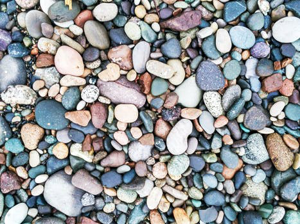

In [5]:
# path='jewels.jpg'
path='stones.jpg'
im=Image.open(path).resize((300,224))
im

In [6]:
means=torch.tensor([0.485,0.456,0.406])
stds=torch.tensor([0.229,0.224,0.225])
norm=TF.Normalize(means.tolist(),stds.tolist())
unnorm=TF.Normalize((-means/stds).tolist(),(1./stds).tolist())
imt=norm(TF.ToTensor()(im))[None].cuda()
imt.shape

torch.Size([1, 3, 224, 300])

In [7]:
def getgrams(x,w_l):
    grams=[]
    for l,w in enumerate(w_l):
        if w==0.: continue
        feats=m_l[l](x)[0]#;print(feats.shape)
        feats=feats.view((len(feats),-1))#;print(feats.shape)
        grams.append(feats@feats.T/feats.shape[-1])
    return grams

In [65]:
w_l=[1,1,1,1,0.]
imgrams=getgrams(imt,w_l)
[len(g) for g in imgrams]

[64, 128, 256, 512]

In [9]:
def getloss(grams1,grams2):
    return sum(F.mse_loss(g1,g2) for g1,g2 in zip(grams1,grams2))/4

In [75]:
x=(torch.randn(1,3,200,200)/10.).cuda().requires_grad_()

0 718.3003540039062
1 663.3707275390625
2 506.104736328125
3 375.8589782714844
4 286.96527099609375
5 221.05303955078125
6 175.4207305908203
7 143.71961975097656
8 121.62591552734375
9 104.29917907714844
10 91.8130111694336
11 81.93212890625
12 74.70664978027344
13 68.6739501953125
14 63.85054016113281
15 59.42707443237305
16 55.611698150634766
17 52.02367401123047
18 48.73713302612305
19 45.554603576660156
20 42.587791442871094
21 39.810768127441406
22 37.25076675415039
23 34.84519577026367
24 32.62042999267578
25 30.608015060424805
26 28.7652645111084
27 27.097759246826172
28 25.550691604614258
29 24.137624740600586
30 22.818822860717773
31 21.595727920532227
32 20.44439697265625
33 19.38557243347168
34 18.413467407226562
35 17.51897621154785
36 16.684537887573242
37 15.912580490112305
38 15.192055702209473
39 14.525237083435059
40 13.907876014709473
41 13.332704544067383
42 12.795154571533203
43 12.290310859680176
44 11.823204040527344
45 11.38750171661377
46 10.976360321044922
47 1

367 1.6351311206817627
368 1.5676472187042236
369 1.4568548202514648
370 1.4085299968719482
371 1.4398760795593262
372 1.5092600584030151
373 1.593573808670044
374 1.634906530380249
375 1.6495203971862793
376 1.5534605979919434
377 1.4469897747039795
378 1.392432451248169
379 1.425163984298706
380 1.5054302215576172
381 1.5741244554519653
382 1.6333034038543701
383 1.5918357372283936
384 1.5058765411376953
385 1.401316523551941
386 1.379582166671753
387 1.4347259998321533
388 1.510585069656372
389 1.592958688735962
390 1.6069999933242798
391 1.5717476606369019
392 1.4473061561584473
393 1.3670175075531006
394 1.3793281316757202
395 1.4516899585723877
396 1.547237753868103
397 1.603338360786438
398 1.6207623481750488
399 1.5059419870376587
275.50987434387207 s
400 1.3903082609176636
401 1.3478388786315918
402 1.3995964527130127
403 1.5012487173080444
404 1.5957825183868408
405 1.69192373752594
406 1.6389901638031006
407 1.5163239240646362
408 1.3633286952972412
409 1.3494138717651367
41

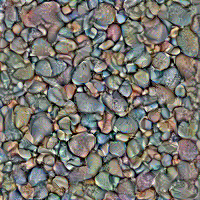

In [76]:
lr=.1
n_ep=500

opt=optim.Adam([x],lr=lr)
t0=time()
for ep in range(n_ep):
    grams=getgrams(x,w_l)
    loss=getloss(grams,imgrams)
    print(ep,loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()
    if (ep+1)%100==0: print(time()-t0,'s')
print('total time:',time()-t0,'s')
TF.ToPILImage()(unnorm(x[0].cpu()).clamp(0,1))